In [3]:
import pandas as pd
import numpy as np
import _dcnpnmf
import matplotlib.pylab as plt
import seaborn as sns


In [4]:
import _sim
import importlib
importlib.reload(_sim)

N=100
K=10
P=1000

H = _sim.generate_H(N, K)
W = _sim.generate_W(P, K)
R = np.matmul(H.T, W.T) 
X = np.random.poisson(R)
print(H.shape)
print(W.shape)
print(R.shape)
print(X.shape)

(10, 100)
(1000, 10)
(100, 1000)
(100, 1000)


<AxesSubplot:>

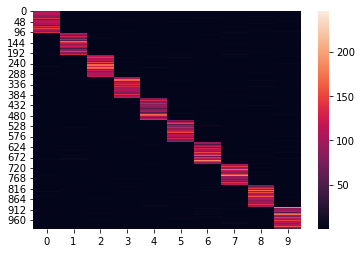

In [5]:
sns.heatmap(W)

1. Run degree correction model only

In [6]:

model = _dcnpnmf.DCNPoissonMF()
model.fit_null(np.asarray(X))



updating null model....
	After ITERATION: 0	Objective: 908022024.02	Old objective: -inf	Improvement: nan
	After ITERATION: 1	Objective: 908022024.02	Old objective: 908022024.02	Improvement: 0.00000




/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcnpnmf.py:56: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


In [11]:
pd.DataFrame(W.T).iloc[9,:].sort_values(ascending=False)

962    245.651438
958    219.462741
968    202.045138
902    183.976754
928    173.061525
          ...    
34       0.005593
814      0.004717
157      0.003662
42       0.003522
233      0.001320
Name: 9, Length: 1000, dtype: float64

In [10]:
pd.DataFrame(model.EF).iloc[0,:].sort_values(ascending=False)

962    0.002295
958    0.002023
454    0.002005
824    0.001973
303    0.001935
         ...   
404    0.000408
628    0.000401
491    0.000391
890    0.000380
905    0.000346
Name: 0, Length: 1000, dtype: float64

In [14]:
pd.DataFrame(H.T).iloc[:,1].sort_values(ascending=False)


13    181.506343
15    155.500543
10    129.595513
12    106.145002
14     96.785734
         ...    
1       0.052301
37      0.050078
93      0.043268
74      0.019631
75      0.002824
Name: 1, Length: 100, dtype: float64

In [15]:
pd.DataFrame(model.ED.T).iloc[0,:].sort_values(ascending=False)

72    2.518681e+06
34    2.444147e+06
13    2.203097e+06
85    2.109216e+06
67    2.102542e+06
          ...     
37    8.615580e+05
16    7.912740e+05
52    7.871930e+05
38    6.965480e+05
19    6.721210e+05
Name: 0, Length: 100, dtype: float64